# 10 Years of Crowdfunding on Kickstarter Exploratory Analysis
## by Marie-Luise Klaus

## Investigation Overview

This exploratory data analysis is dedicated to the 10th anniversary of the crowdfunding platform Kickstarter in April 2019. The main goal is to analyze current trends and determine possible factors contributing to the success of a campaign. Throughout the course of this notebook, I will have two main questions in mind. Based on our data, I'm going to investigate:

**1) Is it still worth the effort to finance your project on Kickstarter since crowdfunding has become mainstream?**  
**2) What determines the success of a crowdfunding campaign on Kickstarter?**

## Dataset Overview

The Kickstarter data set was gathered in April 2019 from an automated web scraping service called web robots. They have been publishing monthly data of all ongoing and completed Kickstarter projects and released it to the public in the form of csv files on their website.

https://webrobots.io/kickstarter-datasets/

After assessing and cleaning the data, we got applicable information on 10 years of Kickstarter campaigns, from Kickstarter's launch in April 2009 to mid-April 2019. In the focus of my analysis were the remaining 169,661 observations of completed projects with 22 features describing each project. The main feature of interest was the status of a project, which states whether the crowdfunding was successful or failed. Supported was this by investigating how project characteristics were associated with the success of a campaign. I suspected the following factors to be most influential on the project: the funding goal, successfully pledged dollars, the number of backers, the promotional support provided by Kickstarter, the dates of campaigns and the project category.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
sns.set_style("whitegrid")

In [2]:
# read in 4 files and concatinate the data into a single pandas data frame
file_name =  './data/kickstarter_master{}.csv'
master_df = pd.concat([pd.read_csv(file_name.format(i)) for i in range(1,5)])
master_df.reset_index(drop=True, inplace=True)

In [3]:
# convert time data to date time format
master_df[['created_at', 'launched_at', 'state_changed_at', 'deadline', 'last_update_at']] = master_df[['created_at', 'launched_at', 'state_changed_at', 'deadline', 'last_update_at']].apply(pd.to_datetime)

# engineer variable to asses funding duration
master_df['duration'] = master_df['deadline'] - master_df['launched_at']
master_df[['launched_at', 'deadline', 'duration']].sample(5)

# convert duration time delta to float of days
master_df['duration_days'] = (master_df['duration'].astype('timedelta64[h]') / 24)

# create combined category
master_df['comb_cat'] = master_df['category'] + "/" + master_df['subcategory']
master_df[['category', 'subcategory','comb_cat']].sample(5)

# create a separate data frame for completed projects only
ks_compl = master_df.query('(status == "successful") | (status == "failed")')
ks_compl.reset_index(drop=True, inplace=True)
ks_compl.status.value_counts()

# remove columns that are irrelevant to our analysis to keep our dataframe neat
ks_compl = ks_compl.drop(labels=['slug', 'created_at', 'last_update_at', 'state_changed_at', 'displ_loc',
                                 'goal_real', 'goal_current_usd','pledged_real', 'pledged_current_usd', 
                                 'current_fx_rate(usd)', 'hist_exchange_rate(usd)'], axis=1)

In [4]:
# utility to improve readability of large numbers 
def format_num(num):
    num = round(float(num))
    formatted_num = str(num)
    str_length = len(formatted_num)
    cursor = str_length % 3
    if str_length > 3 and cursor > 0:
        formatted_num = formatted_num[0:cursor] + "," + formatted_num[cursor:] 
        cursor += 1
        str_length = str_length - cursor
    while str_length > 3:
        formatted_num = formatted_num[0:cursor+3] + "," + formatted_num[cursor+3:]
        cursor += 4
        str_length -= 3
    return formatted_num


In [5]:
# utility to format yticks
def format_yticks(maximum, step, minimum=0):
    ylocs = np.arange(minimum, maximum+step, step)
    ylabels = [format_num(yloc) for yloc in ylocs]
    plt.yticks(ylocs, ylabels)
    
# utility to format xticks
def format_xticks(maximum, step, minimum=0):
    xlocs = np.arange(minimum, maximum+step, step)
    xlabels = [format_num(xloc) for xloc in xlocs]
    plt.xticks(xlocs, xlabels)

In [6]:
# utility to create xticks for a timeline 
def timeline_ticks(df):    
    x_labels = np.arange('2009-05', '2019-05', 7, dtype='datetime64[M]')
    x_ticks = np.arange(0,len(df), 7)
    plt.xticks(x_ticks,x_labels, rotation=45, ha='right')
    plt.xlabel("")

In [7]:
# remove outlier project with extremely high goals, pledges or backers counts to make visualization and interpretation possible
# identify 95% quantile of each skewed feature
goal_25 = ks_compl.goal_hist_usd.quantile(q=0.25)
goal_50 = ks_compl.goal_hist_usd.quantile(q=0.5)
goal_75 = ks_compl.goal_hist_usd.quantile(q=0.75)
goal_95 = ks_compl.goal_hist_usd.quantile(q=0.95)
goal_975 = ks_compl.goal_hist_usd.quantile(q=0.975)
pledged_95 = ks_compl.pledged_hist_usd.quantile(q=0.95)
backers_95 = ks_compl.backers_count.quantile(q=0.95)

ks_compl_95 = ks_compl.copy()
print("Projects completed : ", format_num(len(ks_compl_95)))

# collect all projects that stay below the 95% quantiles in goal, pledged and backers 
ks_compl_95 = ks_compl_95.query('(goal_hist_usd < @goal_95) & \
                                  (pledged_hist_usd < @pledged_95) & \
                                  (backers_count < @backers_95)')

ks_compl_95.reset_index(drop=True, inplace=True)
print("After removal of outliers: ", format_num(len(ks_compl_95)))

# create separate data frames with outliers removed for each, successful and failed projects
ks_success_95 = ks_compl_95[ks_compl_95.status == 'successful']
ks_fail_95= ks_compl_95[ks_compl_95.status == 'failed']
print("No. success projects 95%.: ", format_num(len(ks_success_95)) , \
      "\nNo. failed projects 95%.:", format_num(len(ks_fail_95)))

Projects completed :  169,661
After removal of outliers:  151,754
No. success projects 95%.:  84,581 
No. failed projects 95%.: 67,173


In [8]:
# utilities
# create separate data frames for successful and failed projects
ks_compl_success = ks_compl[ks_compl.status == "successful"]
ks_compl_failed = ks_compl[ks_compl.status == "failed"]

# frequently used variables 
dates = np.arange('2009-05', '2019-05', dtype='datetime64[M]')

# define commonly used colors
cust_green = '#66cdaa'
cust_red = '#f08080'
cust_blue = '#43a2ca'
status_colors = [cust_blue, cust_green, cust_red]
fill_red = '#fee0d2'
fill_green = '#e0f3db'
backers_color = '#a6611a'
pledged_color = "#c994c7"
goal_color =  sns.color_palette("Blues_r")[0]
feat_color = sns.color_palette("Set1")

# Is it still worth the effort to finance your project on Kickstarter since crowdfunding has become mainstream?

Crowdfunding caused quite a stir in the recent years. More and more project creators recognized crowdfunding as a form of investment and launched campaigns. They were seeking investments from a private audience, instead of professional investors or venture capitalists. Since then, multiple platforms with specific purposes and different types of crowdsourcing evolved globally. With the rise of competitors, campaign creators likely face a bigger challenge courting for attention and investment. 
The general doubts about crowdfunding in news articles inspired me to investigate how crowdfunding as an investment opportunity has evolved over time on Kickstarter. 

Due to Kickstarter's approach to only distribute the collected investment once the funding goal was met, creators end with all or nothing. Because of failure, creators may have to deal with unnecessary loss of reputation or IP theft.

In the light of crowdfunding becoming popular among a large global audience, I'm curious how its popularity affected campaigns on Kickstarter. How exactly have campaign characteristics changed today, on Kickstarter's 10th anniversary, compared to previous years?


## The number of monthly campaigns has been growing again since 2018

After rather slow growth in the first 5 years, we found extreme boosts in crowdfunding activities in August 2014 and March/April 2015. The number of campaigns literally exploded. Project counts settled down thereafter. Nevertheless, with roughly 2,000 projects each month, the number of campaigns ending each month kept on a high level in the following 5 years up until today. Most importantly, we discovered increasing numbers of campaigns since 2018.

## In 2018, 63.5% of campaigns were successful.
With the hype of Kickstarter in late 2014, we found an abnormal high percentage of projects failing: 61% flopped. During the years of recession the likelihood to fail minimally exceeded success rates. 51% of projects failed. By the beginning of 2018, Kickstarter turned success and failure rates upside down. On average, 63.5% of completed campaigns were successful. Actually, the record of successful campaigns was only recently, in March 2019. Chances to win were 74%!

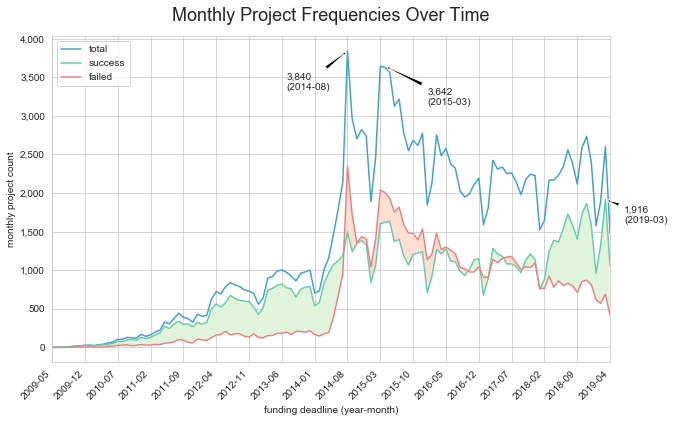

In [9]:
# create dataframe to summarize project counts per month over the course of 120 months
df_project_counts = pd.DataFrame(data={'total': [0.0]*120, 
                              'success':  [0.0]*120, 
                              'failed':  [0.0]*120, 
                              'date': dates})

# fill data frame with absolute project counts per month
for df, label in [(ks_compl, 'total'), (ks_compl_success, 'success'), (ks_compl_failed, 'failed')]:
    # calculate monthly abs. project counts
    counts = df.groupby([df.deadline.dt.year, df.deadline.dt.month])\
                        .count()['project_id']
    # the above grouping ignores months with zero counts, so we manually add zero values
    # re-create a new multi-index, this time including all 12 months per year
    levels = [counts.index.levels[0].values, range(1,13)]
    new_index = pd.MultiIndex.from_product(levels, names=['year', 'month'])
    # re-index counts and fill empty values with zero
    counts = counts.reindex(new_index, fill_value=0).values
    # remove months Jan-April 2014 and, May-Dec 2019 
    counts = counts[4:-8]
    # add to dataframe
    df_project_counts[label] = counts

# settings
plt.figure(figsize=[10,6])

# plot monthly counts of projects of completed projects by month over time
for i, col in enumerate(df_project_counts.columns[:-1]):
    ax = df_project_counts[col].plot(color=status_colors[i])

# annotate peaks
ymax_1  = max(df_project_counts.total)
xmax_1 = str(df_project_counts[df_project_counts.total == ymax_1].date.values[0])[:7]
ax.annotate(format_num(ymax_1) + "\n(" + str(xmax_1) + ")", xy=(63, ymax_1), 
            xytext=(50, ymax_1-500),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

ymax_2  = df_project_counts.total.sort_values().values[-2]
xmax_2 = str(df_project_counts[df_project_counts.total == ymax_2].date.values[0])[:7]
ax.annotate(format_num(ymax_2) + "\n(" + str(xmax_2) +")", xy=(71, ymax_2), 
            xytext=(80, ymax_2-500),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

ymax_3  = max(df_project_counts.success)
xmax_3 = str(df_project_counts[df_project_counts.success == ymax_3].date.values[0])[:7]
ax.annotate(format_num(ymax_3) + "\n(" + str(xmax_3)+")", xy=(118, ymax_3), 
            xytext=(122, ymax_3-300),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))


# highlight differences
ax.fill_between(np.arange(0,120), df_project_counts.success, df_project_counts.failed , 
                where=df_project_counts.failed >= df_project_counts.success, 
                facecolor=fill_red, interpolate=True)
ax.fill_between(np.arange(0,120), df_project_counts.success, df_project_counts.failed, 
                where=df_project_counts.success >= df_project_counts.failed, 
                facecolor=fill_green, interpolate=True)

# # labels and titles
plt.title("Monthly Project Frequencies Over Time", fontsize=18, pad=15)

ylabels = ['{:,.0f}'.format(ytick) for ytick in ax.get_yticks()]
ax.set_yticklabels(ylabels)
plt.ylabel('monthly project count')

timeline_ticks(df_project_counts)
plt.xlabel('funding deadline (year-month)')

plt.legend(loc=2)
plt.show()

## Funding goals of successful campaigns have become lower
I noticed a trend of declining funding goals of successful projects since 2017. While successful projects realized goals of roughly USD 3,100 between 2014 - 2016, creators today usually aimed for goals USD 500 lower. 

Compared to failed campaigns, successful goals have been relatively balanced over the entire time. In contrast, the median goals of failed campaigns increased over the years. Only in 2018 they came to an halt. On Kickstarter's anniversary, failed campaigns tended to seek 3 times higher goals.

In [10]:
def group_data_monthly(feature, median=True):
    if median:
        # total
        grouped = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                                       ks_compl_95.deadline.dt.month]).median()[feature].values
        # success
        grouped_s = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                                           ks_success_95.deadline.dt.month]).median()[feature].values
        # failed
        grouped_f= ks_fail_95.groupby([ks_fail_95.deadline.dt.year, 
                                      ks_fail_95.deadline.dt.month]).median()[feature].values
    else:
        # total
        grouped = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                                       ks_compl_95.deadline.dt.month]).mean()[feature].values
        # success
        grouped_s = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                                           ks_success_95.deadline.dt.month]).mean()[feature].values
        # failed
        grouped_f= ks_fail_95.groupby([ks_fail_95.deadline.dt.year, 
                                       ks_fail_95.deadline.dt.month]).mean()[feature].values
    # insert 0 occurence for 2009-6
    grouped_f = np.insert(grouped_f,1,0) 
        
    # create dataframe
    df = pd.DataFrame(data={'total':grouped, 
                            'success':grouped_s, 
                            'failed': grouped_f, 
                            'date': dates})
    return df

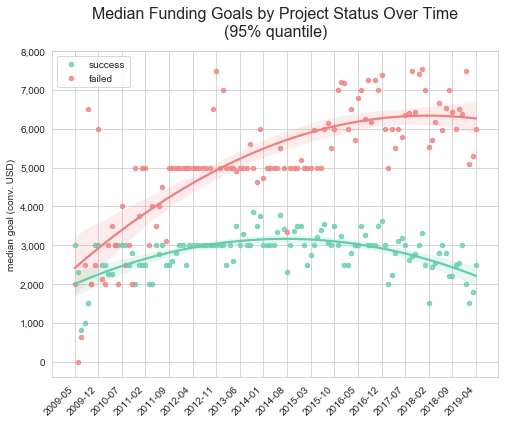

In [11]:
# settings
plt.figure(figsize=[8,6])

# calculate monthly median goals of completed projects of 95 quantile data frame
df_goals = group_data_monthly('goal_hist_usd')

# overwrite date because seabrorn can't plot dates 
df_goals['date'] = np.arange(0, len(df_goals), 1)

# scatterplots of monthly means and fit a polynomial regression of 2nd degree
ax = sns.regplot(x=df_goals['date'], y=df_goals['success'],
                 color=cust_green,
                 scatter_kws={"s": 20},
                 order=2, ci=95, truncate=True, label="success");
ax = sns.regplot(x=df_goals['date'], y=df_goals['failed'],
                 color=cust_red,
                 scatter_kws={"s": 20},
                 order=2, ci=95, truncate=True, label="failed");

# ticks and labels
timeline_ticks(df_goals)
format_yticks(8000, 1000)
plt.ylabel("median goal (conv. USD)")
plt.title("Median Funding Goals by Project Status Over Time\n(95% quantile)", fontsize=16, pad=15)
plt.legend()
plt.show()

## The collected financial backing has been stable
In spite of goals of successful projects tending to be lower nowadays, the overall financial backing per project has been relatively constant since 2014. Recently, the total collected funding even increased slightly. While creators raised a median of USD 5,038 between 2014-2017, they realized USD 5,371 in 2018.

However, if we turn our attention to the plot on right, we notice an extreme discrepancy between goals and pledges. When Kickstarter suddenly boomed in August 2014, the total funding capacity of all completed projects dropped from more than 3,000 down to USD 146. Obviously, the sudden growth of project numbers couldn't keep up pace with the funding available per project. This gap has been slowly closing. Today, the total funding capacity has almost caught up with the total of completed project goals. If this trend continues, it won't take long until all goal requirements could be met. At least in theory.

The most astonishing about the goal-pledges overhead is that successful campaigns were hardly affected by the lack of funding. We can only speculate, that maybe the additional projects brought by the hype were generally not suitable for crowdfunding or the type of campaigns were irrelevant for supporters, so that lost investment dollars were contained.     

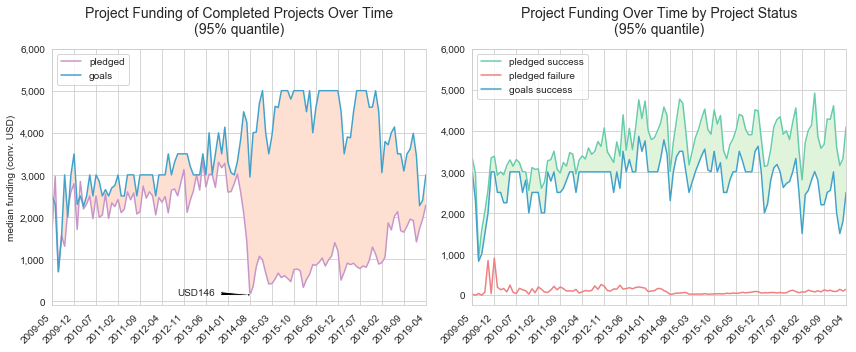

In [15]:
# settings
plt.figure(figsize=[12,5])

# calculate monthly median pledges of completed projects of 95 quantile data frame
df_pledged_median = group_data_monthly('pledged_hist_usd')

# # left plot: line plot of monthly median pledges of all completed projects
plt.subplot(1,2,1)
ax = df_pledged_median.total.plot(color=pledged_color, label='pledged');
ax = df_goals.total.plot(color=cust_blue, label='goals');

# highlight negative differences
ax.fill_between(np.arange(0,120), df_pledged_median.total, df_goals.total , 
                where=df_goals.total >= df_pledged_median.total, 
                facecolor=fill_red, interpolate=True)

# annotate minima
ymin  = min(df_pledged_median.total)
xmin = str(df_pledged_median[df_pledged_median.total == ymin].date.values[0])[:7]
ax.annotate("USD" + format_num(ymin), xy=(64, ymin), 
            xytext=(40, ymin),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_median)
plt.tight_layout()
format_yticks(6000,1000)
plt.ylabel("median funding (conv. USD)")
plt.title("Project Funding of Completed Projects Over Time\n(95% quantile)", fontsize=14, pad=15)
plt.legend(loc=2)

# right plot: line plots of monthly median pledged of successful anf failed projects
plt.subplot(1,2,2)
ax = df_pledged_median.success.plot(color=cust_green, label="pledged success");
ax = df_pledged_median.failed.plot(color=cust_red, label="pledged failure");
# add goals to compare
ax = df_goals.success.plot(color=cust_blue, label='goals success');

# highlight overhead
ax.fill_between(np.arange(0,120), df_pledged_median.success, 
                df_goals.success , where=df_pledged_median.success >= df_goals.success, 
                facecolor=fill_green, interpolate=True)

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_median)
format_yticks(6000,1000)
plt.ylabel("")
plt.title("Project Funding Over Time by Project Status\n(95% quantile)", fontsize=14, pad=15)
plt.tight_layout()
plt.legend()
plt.show()

## Today supporters tend to pledge smaller amounts.
The money each supporter spent on incentives has been declining lately. In 2018, successful projects on average collected USD 7 less per backer than in the record year of 2016. Creators had to attract a higher number of supporters to collect the same amount of funding. This may be a negative development for some creators, but it may also be a strategic chance for business starters to increase their reach, funding or customer numbers.

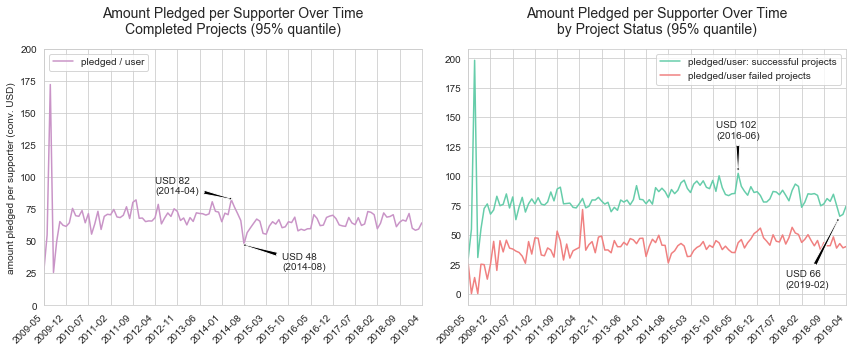

In [16]:
# settings
plt.figure(figsize=[12,5])

# add the average amount pledged per supporter to each campaign of the 95% quantile data
for df in [ks_compl_95, ks_success_95, ks_fail_95]:
    df['pledged_rate'] = (df['pledged_hist_usd'] / df['backers_count']).fillna(0)

# calculate monthly median pledged rate of completed projects of 95 quantile data frame
df_pledged_rate = group_data_monthly('pledged_rate', False)

# # left plot: line plot of monthly relative pledges for all completed projects
plt.subplot(1,2,1)
ax = df_pledged_rate.total.plot(color=pledged_color, label='pledged / user');

# annotate peaks
# peak in 4/2014
ymax_1  = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                              ks_compl_95.deadline.dt.month])['pledged_rate']\
                              .mean().sort_values().values[-2]
xmax_1 = str(df_pledged_rate[df_pledged_rate.total == ymax_1].date.values[0])[:7]
ax.annotate("USD " + format_num(ymax_1)  + "\n(" + str(xmax_1) +")", xy=(60, ymax_1), 
            xytext=(35, ymax_1+5),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# low in 08/2014
ymin = ks_compl_95.groupby([ks_compl_95.deadline.dt.year, 
                            ks_compl_95.deadline.dt.month])['pledged_rate']\
                            .mean().sort_values().values[2]
xmin = str(df_pledged_rate[df_pledged_rate.total == ymin].date.values[0])[:7]
ax.annotate("USD " + format_num(ymin)  + "\n(" + str(xmin) +")", xy=(62, ymin), 
            xytext=(75, ymin-20),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_rate)

# improve readability of y ticks
plt.yticks(np.arange(0, 201, 25))
plt.ylabel("amount pledged per supporter (conv. USD)")
plt.title("Amount Pledged per Supporter Over Time\nCompleted Projects (95% quantile)", fontsize=14, pad=15)
plt.legend(loc=2)

# right plot: line plot of onthly relative pledges, divided into successful anf failed projects
plt.subplot(1,2,2)
ax = df_pledged_rate.success.plot(color=cust_green, label="pledged/user: successful projects");
ax = df_pledged_rate.failed.plot(color=cust_red, label="pledged/user failed projects");

# annotate peaks
# peak in 6/2016
ymax_3  = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                              ks_success_95.deadline.dt.month])['pledged_rate']\
                              .mean().sort_values().values[-2]
xmax_3 = str(df_pledged_rate[df_pledged_rate.success == ymax_3].date.values[0])[:7]
ax.annotate("USD " + format_num(ymax_3)  + "\n(" + str(xmax_3) +")", xy=(85, ymax_3), 
            xytext=(78, ymax_3+30),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# low in 08/2014
ymin_2 = ks_success_95.groupby([ks_success_95.deadline.dt.year, 
                              ks_success_95.deadline.dt.month])['pledged_rate']\
                              .mean().sort_values().values[5]
xmin_2 = str(df_pledged_rate[df_pledged_rate.success == ymin_2].date.values[0])[:7]
ax.annotate("USD " + format_num(ymin_2)  + "\n(" + str(xmin_2) +")", xy=(117, ymin_2), 
            xytext=(100, ymin_2-60),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_pledged_rate)
plt.ylabel("")
plt.yticks(np.arange(0, 201, 25))
plt.title("Amount Pledged per Supporter Over Time\nby Project Status (95% quantile)", fontsize=14, pad=15)
plt.tight_layout()
plt.legend()
plt.show()

## Growing supporter numbers compensated for increased competition among creators.
We would expect the recent increase of competing projects, lower funding goals and the tendency to pledge greedier to negatively impact campaigns. However, with Kickstarter becoming mainstream, the number of people who supported a project has been increasing stronger than the number of active campaigns. While a lack of funding/supporters caused severe failure rates during the hype years, the backer/project ratio has been increasing since 2015. Therefore, success rates and the overall funding capacity has been stabilizing. In October 2018, there was even a record median of 72 backers supporting each project.

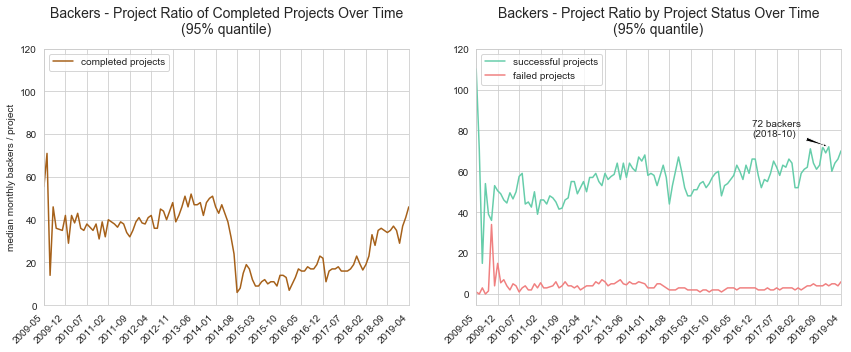

In [17]:
# settings
plt.figure(figsize=[12,5])

# calculate monthly median pledged rate of completed projects of 95 quantile data frame
df_backers_r = group_data_monthly('backers_count')

# left plot: line plot of median backers by completed projects
plt.subplot(1,2,1)
ax = df_backers_r.total.plot(color=backers_color, label='completed projects');

# ticks and labels
plt.xlabel("")
timeline_ticks(df_backers_r)
plt.yticks(np.arange(0, 121, 20))

plt.ylabel("median monthly backers / project")
plt.title("Backers - Project Ratio of Completed Projects Over Time\n(95% quantile)", fontsize=14, pad=15)
plt.legend(loc=2)

# right plot: line plots of avg backers by successful or failed project
plt.subplot(1,2,2)
ax = df_backers_r.success.plot(color=cust_green, label="successful projects");
ax = df_backers_r.failed.plot(color=cust_red, label="failed projects");

# annotate recent maximum
ymax_1  = df_backers_r.success.sort_values().values[-3]
xmax_1 = str(df_backers_r[df_backers_r.success == ymax_1].date.values[0])[:7]
ax.annotate(format_num(ymax_1)+ " backers\n(" + str(xmax_1)+")", xy=(115, ymax_1), 
            xytext=(90, ymax_1+5),
            arrowprops=dict(facecolor='black', arrowstyle="fancy"))

# ticks and labels
plt.xlabel("")
timeline_ticks(df_backers_r)
plt.yticks(np.arange(0, 121, 20))
plt.ylabel("")
plt.title("Backers - Project Ratio by Project Status Over Time\n(95% quantile)", fontsize=14, pad=15)
plt.tight_layout()
plt.legend(loc=2)
plt.show()

## Better chances to be promoted by Kickstarter.
In spite of growing campaign numbers, Kickstarter promotes a higher percentage of projects on their landing page (and possibly social channels) since the beginning of 2018. Today, more than 60% of all fundings are spotlighted on Kickstarter's channels. The proportion of unsupported projects has been decreasing from 55% in the hype years to only 27% today.   

Additionally, more projects than ever are additionally picked by staff to be awarded the "Projects We Love" badge as the proportion of fully supported projects has kept constant at at rate of 10%.

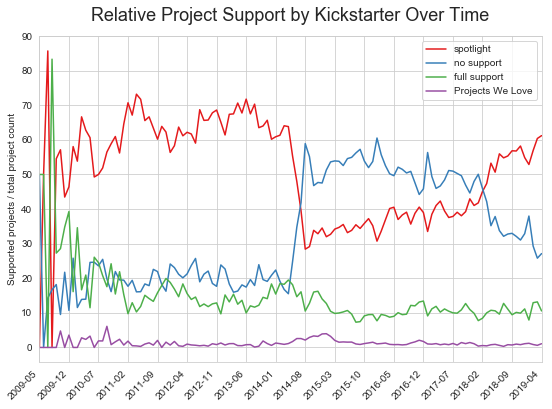

In [18]:
# create empty dataframe
df_featured = pd.DataFrame(data={'no support': [0.0]*120,
                                'Projects We Love': [0.0]*120, 
                                'spotlight': [0.0]*120, 
                                'full support': [0.0]*120, 
                                'date': dates})

# fill data frame with absolute project counts of every feature
for label, df in ks_compl.groupby([ks_compl.featured]):
    # calculate monthly abs. project counts
    counts = ks_compl[ks_compl.featured == label].groupby([ks_compl.deadline.dt.year, 
                                                           ks_compl.deadline.dt.month]).size()
    # the above grouping ignores months with zero counts, so we manually add zero values
    # re-create a new multi-index, this time including all 12 months per year
    levels = [counts.index.levels[0].values, range(1,13)]
    new_index = pd.MultiIndex.from_product(levels, names=['year', 'month'])
    # re-index counts and fill empty values with zero
    counts = counts.reindex(new_index, fill_value=0).values
    # remove months Jan-April 2014 and, May-Dec 2019 
    counts = counts[4:-8]
    # add to dataframe
    df_featured[label] = counts
    
# calculate relative project support by dividing featured project counts by monthly project counts
for label in ks_compl.featured.value_counts().index:
    df_featured[label] = (df_featured[label] / df_project_counts['total'])*100
    
# Visualize how Kickstarter supported projects over time in relative values
# settings
plt.figure(figsize=[9,6])

# plot each featured value on a line 
for label in ks_compl.featured.value_counts().index:
    ax = df_featured[label].plot(color=sns.set_palette(feat_color),label=label);
    
# ticks and labels
timeline_ticks(df_featured)
plt.xlabel("")

plt.yticks(np.arange(0, 90+10, 10))
plt.ylabel("Supported projects / total project count");

plt.title("Relative Project Support by Kickstarter Over Time", fontsize=18, pad=15);
plt.legend()
plt.show()

# 2) What determines the success of a crowdfunding campaign on Kickstarter?
To determine whether a campaign was considered successful or not, we looked into two main factors: first, the general chance to successfully run a funding, and second, the amount of funding that was ultimately collected. 

When creators decide on a goal, they generally have to ponder whether to maximize their chances to successfully end a campaign or to generate the maximum funding possible. Both targets oppose each other diametrically. Because of Kickstarter's all-or-nothing-approach, raising the goal typically decreases the chances to succeed, yet creators risk insufficient funding by aiming for low goals.

## Goals

Let's understand the distribution of goals first. There is a extremely wide scope of funding goals. They can range from zero to USD 150 mi. However, 95% of projects were below goals of USD 65 k. The median goal was only USD 5 k. We experience very strong outliers at the high end of funding goals that go up into several millions.

The median goals benchmark at 5 tsd. 95% of projects were below goals of USD 65,064. However, goals sharply increased up into millions above the 97.5% quantile. But only a very few projects rocket very high in the range of several million.

Generally speaking, lower funding goals under ~15,000 are more common. 
e highest peak is at the median of USD 5,000, the second highest peak is at USD 10,000.
Plotting the actually goals up to 150,099,319 would skew the curve further and result in an unreadable plot. Notice the accumulation of low funding goals and the long right tail of the plot. Characteristic for the above distribution are the multimodal peaks of funding goals that seem to occur on a regular frequency.

To better understand the distribution of funding goals, I will again plot the goal distribution of all completed project; this time using a logarithmic scale.
However, by using a log scale, the above visualization hides the extremely skewed nature of funding goals and may lead to misinterpretation. Moreover, the local maxima of funding goals are not as obvious. To bring the analysis of goals to the next level, I'm going to split goals into groups based on their aforementioned quantiles.
Our plots show a right-skewed goal distribution across all goal levels with multimodal peaks. Typically, there are peaks around whole numbers. The most frequent goals are: USD 5,000, USD 10,000, USD 1,000 and USD 3,000.

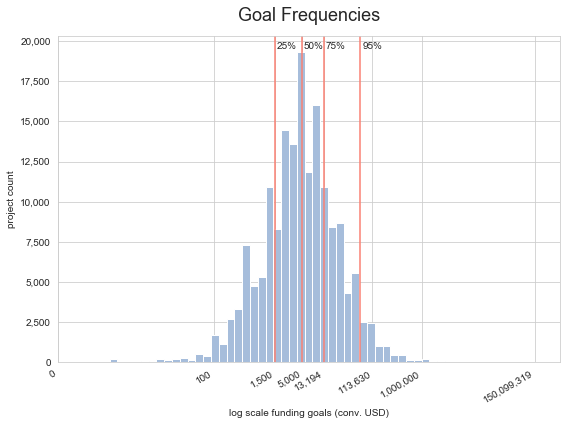

In [19]:
# settings
plt.figure(figsize=[9,6])
base_color = sns.color_palette("Blues_r")[0]

# create log scale and bin data 
log_data = np.log10(ks_compl.goal_hist_usd)
log_bin_edges = np.arange(0, log_data.max()+0.15, 0.15)

# plot histogram using binned log data 
plt.hist(log_data, bins = log_bin_edges, color="#a6bddb");

ax = plt.gca()
# annotate quantiles
for q, text in zip([goal_25, goal_50, goal_75, goal_95], ["25%", "50%", "75%", "95%"]):
    # calculate log quantile
    log_q = np.log10(q)
    ax.axvline(x=log_q, color='salmon', ymax=1, linestyle="-")
    ax.annotate(text, xy=(log_q*1.01, 19500),fontsize=10)

# labels and ticks
plt.title("Goal Frequencies", fontsize=18, pad=15)

format_yticks(20000, 2500)
plt.ylabel("project count")

x_ticks = [0.1, 100, goal_25, goal_50,  round(goal_75, 2), round(goal_975,2), 1000000, round(ks_compl['goal_hist_usd'].max()) ]
x_tick_labels = [format_num(x_tick) for x_tick in x_ticks]
plt.xticks(np.log10(x_ticks), x_tick_labels, rotation=30, ha='right')
plt.xlabel('log scale funding goals (conv. USD)')

plt.show()

## The lower the goal the better.
If creators want to keep at least a 50% chance, it appears to be advisable to stay below a benchmark of USD 10,000, leaving all other effects aside. On average goals below 5,000 had a chance above 60%. Very risk-averse creators may even stick goals below USD 1,500.   

 Creators seeking high funding may consider alternative investment possibilities to Kickstarter. 95% of all successful projects stay below funding of USD 38k. At the same time, success chances are very low for very high goal projects between USD 65k to 113k : only 20% of campaigns end in success. For even higher goals, success chances draw closer to zero.

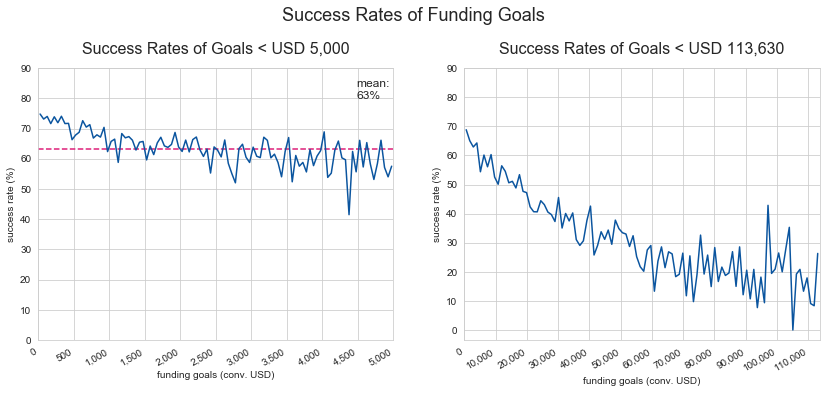

In [20]:
# utility to bin data
def bin_data(df):
    # create bin edges for goals
    bin_size = (df['goal_hist_usd'].max()-df['goal_hist_usd'].min()) / 100
    bins = np.arange(df['goal_hist_usd'].min(),df['goal_hist_usd'].max()+bin_size, bin_size)
    # create bin centers to plot them in their accurate positions
    # leave out the the last value, since it doesn't correspond to an actual bin center  
    bins_c = bins[:-1] + bin_size/2
    # Use cut function to bin values into discrete intervals to segment and sort data values into bins. 
    # for all goals
    goals_binned = pd.cut(df['goal_hist_usd'], bins, include_lowest = True)
    # successful goals
    goals_binned_success = pd.cut(df[df.status == 'successful']['goal_hist_usd'], bins, include_lowest = True)
    return {'total': goals_binned, 'success': goals_binned_success, 'bins': bins_c}

# utility to plot success rates
def plot_success_r(goals_binned, mean=True):
    # calculate success rate for every bin
    success_r = (goals_binned['success'].value_counts(sort=False) / goals_binned['total'].value_counts(sort=False)*100).values
    # plot success rates as adapted line plot to emphasize relative change
    plt.errorbar(x = goals_binned['bins'], y = success_r, color=goal_color)
    # plot success mean
    if mean:
        plt.axhline(success_r.mean(), color='#dd1c77', linestyle='--')
        plt.annotate("mean:\n" + str(int(round(success_r.mean()))) + "%", xy=(goals_binned['bins'].max()*0.9, 80), fontsize=12)

# settings
plt.figure(figsize=[14,5])
goal_50 = ks_compl['goal_hist_usd'].median()
goal_975 = ks_compl['goal_hist_usd'].quantile(q=0.975)

plt.subplot(1,2,1)
# plot low to moderately high goals
goals_binned = bin_data(ks_compl[ks_compl['goal_hist_usd'] < goal_50])
plot_success_r(goals_binned)

# ticks and labels
plt.title("Success Rates of Goals < USD " + format_num(goal_50), fontsize=16, pad=15)

locs = np.arange(0, goal_50+500, 500)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("funding goals (conv. USD)")
plt.xlim(0, goal_50)

plt.yticks(np.arange(0, 91, 10))
plt.ylabel("success rate (%)")

plt.subplot(1,2,2)
# plot low to moderately high goals
goals_binned = bin_data(ks_compl[ks_compl['goal_hist_usd'] < goal_975])
plot_success_r(goals_binned, False)

# ticks and labels
plt.title("Success Rates of Goals < USD " + format_num(goal_975), fontsize=16, pad=15)

locs = np.arange(0, 130000+10000, 10000)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("funding goals (conv. USD)")
plt.xlim(0, goal_975)

plt.yticks(np.arange(0, 91, 10))
plt.ylabel("success rate (%)")

plt.suptitle("Success Rates of Funding Goals ", fontsize=18, y=1.05)
plt.show()        

## Low goals realize outstanding surplus rates

The plots illustrate that the surplus creators realize depends on the goal chosen. For goals under USD 3,000 the surplus rate describes a curve of exponential decay. The lower the goal chosen, the higher the surplus rate. Low goal projects typically generate a surplus of 34% above goal. Whereas goals between USD 1,500 to 13,194 generate a median surplus of 11-12%. Therefore, the loss in the total funding by setting low goals may be tolerable in exchange for better chances of success.

For goals above USD 18,000, we observe increasing surplus rates. Towards high goals above USD 45,000, the pledged surplus rate grows steeper. At the same time, the plot becomes more volatile with anormalous peaks getting extremer. However, this is hardly relevant, since 3 quarters of creators stick to goals below USD 13,000

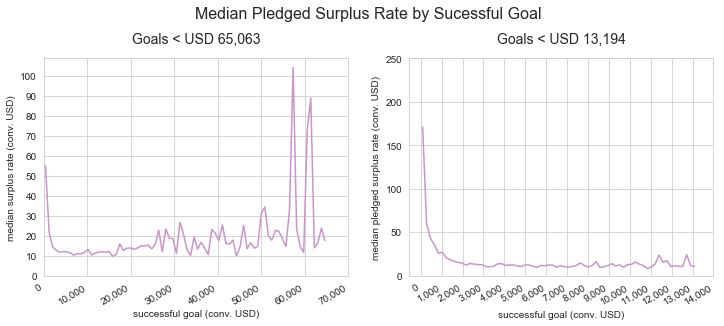

In [21]:
# settings
plt.figure(figsize=[12,4])

def binned_pledges(df, bin_count):
    # cluster goals
    bin_size = (df['goal_hist_usd'].max()-df['goal_hist_usd'].min()) / bin_count
    bin_edges = np.arange(df['goal_hist_usd'].min(), df['goal_hist_usd'].max()+bin_size, bin_size)
    bin_centers = bin_edges[:-1] + bin_size/2
    pd.set_option('mode.chained_assignment', None) # turn off warning
    df['goal_bin'] = pd.cut(df['goal_hist_usd'], bin_edges, labels=bin_centers)
    # calculate median surplus rate for every goal
    df_binned = df['surplus_r'].groupby([df.goal_bin]).median().reset_index()
    return df_binned

# calculate relative differences between goal and pledged of successful campaigns
ks_compl['surplus'] = ks_compl['pledged_hist_usd'] - ks_compl['goal_hist_usd'] 
ks_compl_95['surplus'] = ks_compl_95['pledged_hist_usd'] - ks_compl_95['goal_hist_usd'] 
ks_compl['surplus_r'] = abs(ks_compl['surplus'] / ks_compl['goal_hist_usd']) *100 
ks_compl_95['surplus_r'] = abs(ks_compl_95['surplus'] / ks_compl_95['goal_hist_usd']) *100 
ks_compl_success = ks_compl[ks_compl.status == 'successful']

# left plot: binned median pledges and respective binned goals 
plt.subplot(1,2,1)
# for successfull campaigns with goals below 95%-quantile 
ks_goal_95_s = ks_compl_success[ks_compl_success.goal_hist_usd < goal_95]
df_binned = binned_pledges(ks_goal_95_s, 80)
plt.errorbar(x = df_binned['goal_bin'], y = df_binned['surplus_r'], color=pledged_color ) 
plt.title("Goals < USD " + format_num(int(goal_95)), fontsize=14, pad=15)
    
locs = np.arange(0, 65000+10000, 10000)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("successful goal (conv. USD)")
plt.xlim(0, 70000)

plt.yticks(np.arange(0, 100+10, 10))
plt.ylabel("median surplus rate (conv. USD)")

# right plot: binned median pledges vs. respective binned goals: moderately high goals (50% quantile)
plt.subplot(1,2,2)
goal_75 = ks_compl['goal_hist_usd'].quantile(q=0.75)
df_binned = binned_pledges(ks_compl_success[ks_compl_success.goal_hist_usd < goal_75], 70)
plt.errorbar(x = df_binned['goal_bin'], y = df_binned['surplus_r'], color=pledged_color ) 
plt.title("Goals < USD " + format_num(goal_75), fontsize=14, pad=15)
    
locs = np.arange(0, goal_75+1000, 1000)
labels = [str(format_num(loc)) for loc in locs]
plt.xticks(locs, labels, rotation=30, ha='right')
plt.xlabel("successful goal (conv. USD)")

format_yticks(250, 50)
plt.ylabel("median pledged surplus rate (conv. USD)")

plt.suptitle("Median Pledged Surplus Rate by Sucessful Goal", fontsize=16, y=1.06)
plt.show()


## (Visualization 2)

> You should have at least three visualizations in your presentation,
but feel free to add more if you'd like!

> Once you're ready to finish your presentation, check your output by using
nbconvert to export the notebook and set up a server for the slides. From the
terminal or command line, use the following expression:
> > `jupyter nbconvert <file_name>.ipynb --to slides --post serve --template output_toggle`

> This should open a tab in your web browser where you can scroll through your
presentation. Sub-slides can be accessed by pressing 'down' when viewing its parent
slide. Make sure you remove all of the quote-formatted guide notes like this one
before you finish your presentation!